# Data preprocessing

In [2]:
import numpy as np
import math
import pandas as pd
import os
import matplotlib.pyplot as plt

Read Dataset

In [3]:
path = os.path.join("dataset", "fer2013", "fer2013", "fer2013.csv")
df =  pd.read_csv(path, delimiter=",", header=0)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Figure out the dimension of the images (48x48)

In [4]:
len(df["pixels"][0])
math.sqrt(len(df.pixels[0].split(" ")))

48.0

Code to check wether the number of pixels of any of the images in the dataset aren't perfect squares

In [5]:
pixel_count = len(df.pixels[0].split(' '))

for i in range(0, len(df["pixels"])):
    if not math.sqrt(pixel_count).is_integer():
        print(i)

expected_pixels = 48 * 48
for i in range(0, len(df["pixels"])):
    if pixel_count != expected_pixels:
        print(i)

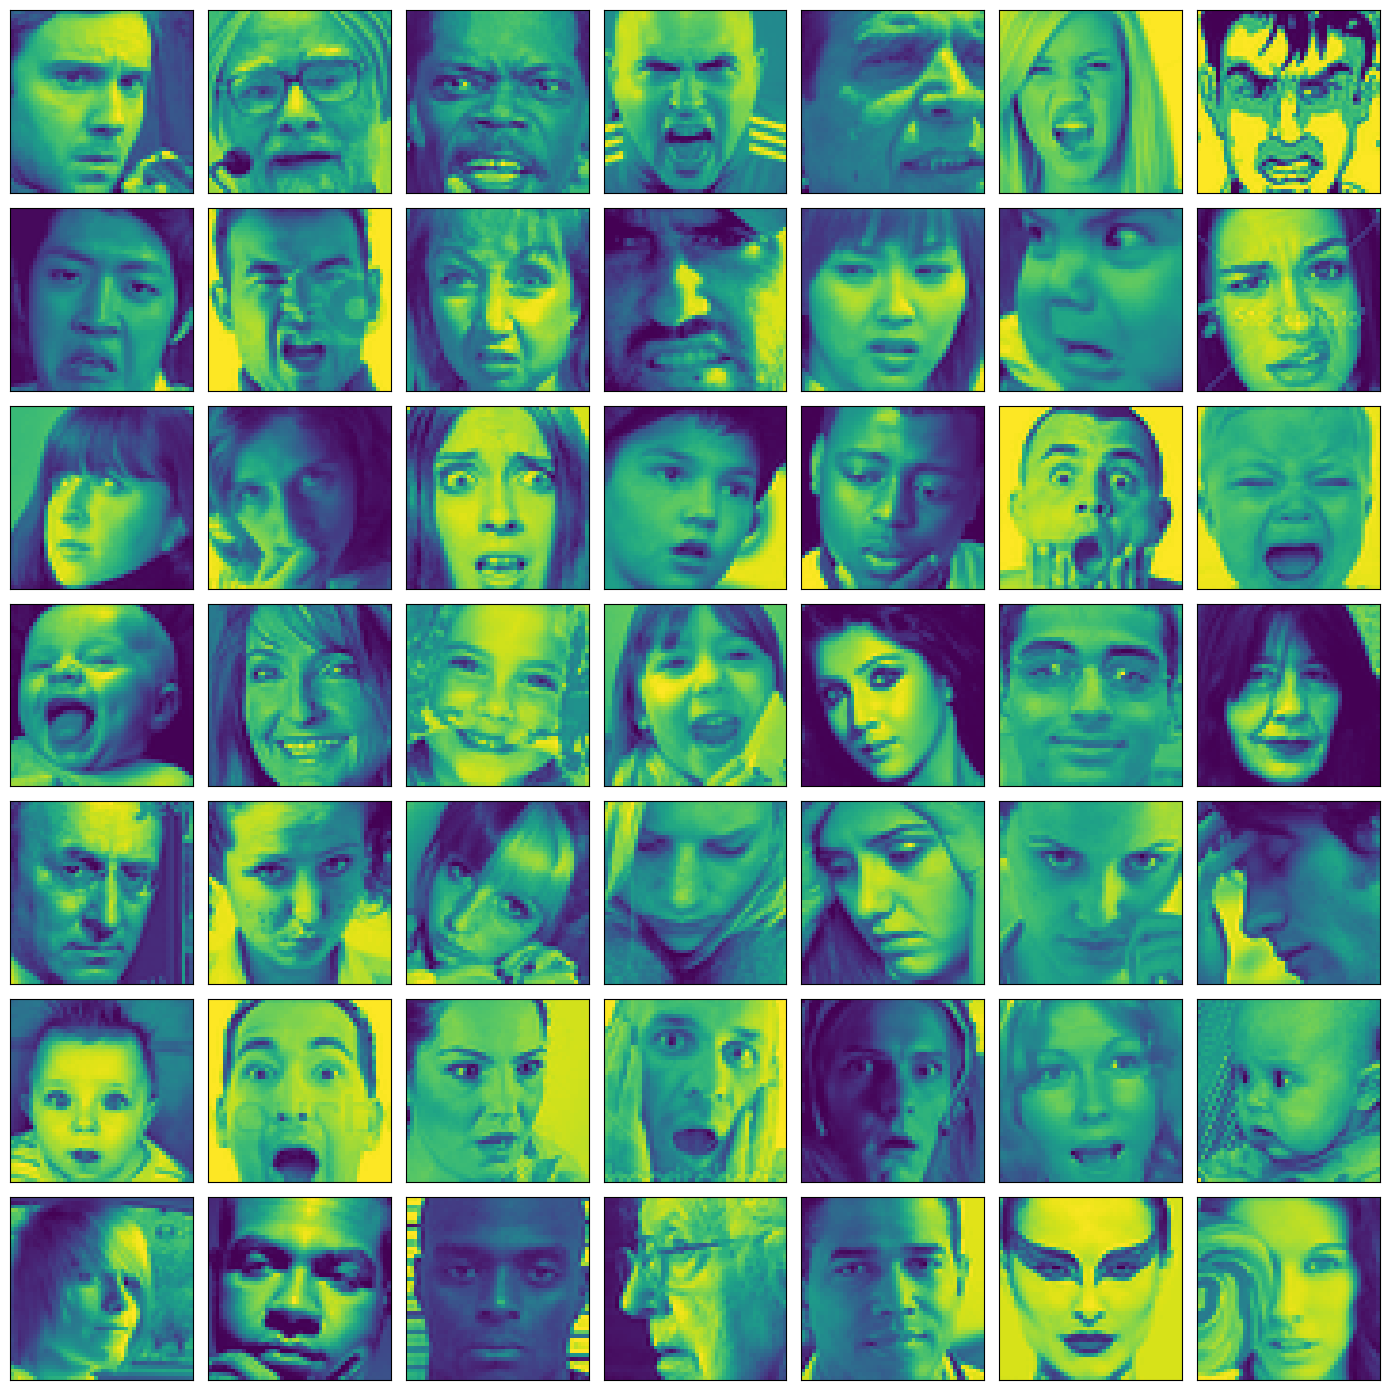

In [6]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df["emotion"].unique()):
    for j in range(7):
        px = df[df["emotion"]==label]["pixels"].iloc[k]
        px = np.array(px.split(" ")).reshape(48, 48).astype("float32")

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()

Converts all strings of pixels into a numpy-array of floating point numbers

In [7]:
df["pixels"] = df["pixels"].apply(lambda x: np.array(x.split(" ")).astype("float32"))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


Apply gaussian blur to all the images

In [8]:
import cv2

df["pixels"] = df["pixels"].apply(lambda x: cv2.GaussianBlur(x, (3, 3), 0))
df.head()

,emotion,pixels,Usage
0,0,"[[75.0], [78.0], [79.0], [71.0], [61.5], [58.5...",Training
1,0,"[[150.5], [149.5], [149.75], [151.25], [146.0]...",Training
2,2,"[[221.5], [202.75], [172.0], [164.5], [162.5],...",Training
3,4,"[[28.0], [31.0], [33.5], [32.0], [29.25], [24....",Training
4,6,"[[2.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0....",Training


In [9]:
df["pixels"] = df["pixels"].apply(lambda x: x.reshape(48, 48))
df.head()

,emotion,pixels,Usage
0,0,"[[75.0, 78.0, 79.0, 71.0, 61.5, 58.5, 60.25, 6...",Training
1,0,"[[150.5, 149.5, 149.75, 151.25, 146.0, 131.25,...",Training
2,2,"[[221.5, 202.75, 172.0, 164.5, 162.5, 152.75, ...",Training
3,4,"[[28.0, 31.0, 33.5, 32.0, 29.25, 24.25, 20.25,...",Training
4,6,"[[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Training


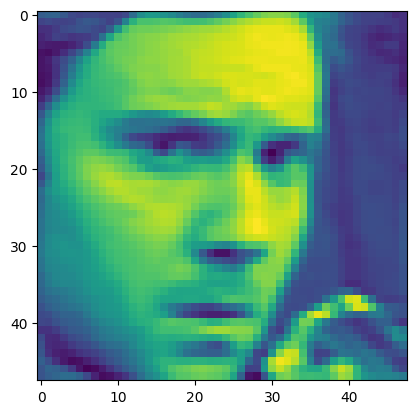

In [10]:
plt.imshow(df["pixels"][0].astype(np.uint8))

Normalize pixel values to between 0 and 1

In [11]:
df["pixels"] = df["pixels"].apply(lambda x: x / 255.0)
df["pixels"][0]

array([[0.29411766, 0.30588236, 0.30980393, ..., 0.20392157, 0.1754902 ,
        0.18627451],
       [0.22745098, 0.24019608, 0.22941177, ..., 0.21372549, 0.2       ,
        0.18627451],
       [0.18333334, 0.18627451, 0.21078432, ..., 0.19117647, 0.20392157,
        0.18431373],
       ...,
       [0.30392158, 0.25784314, 0.18235295, ..., 0.29313725, 0.22254902,
        0.21470588],
       [0.2735294 , 0.3137255 , 0.30392158, ..., 0.3735294 , 0.28529412,
        0.23431373],
       [0.26666668, 0.2990196 , 0.32058823, ..., 0.40784314, 0.39803922,
        0.3745098 ]], dtype=float32)

Split dataset into testing and training sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df["pixels"], df["emotion"], test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((28709,), (7178,), (28709,), (7178,))